In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# **STEP 1: Load and Split Dataset**

In [25]:
df = pd.read_csv("/content/df_with_stockcode_rfm1.csv")

In [26]:
#Display First Five Rows
display(df.head())

,UnitPrice,QuantityAbsolute,TotalAmount,Year,Month,Day,DayOfWeek,Hour,StockCode,Quantity,...,wreath,writing,yellow,yellowblue,youre,yuletide,zinc,Recency,Frequency,Monetary
0,-0.787370,-0.009966,-0.468966,0.269665,1.306861,-0.678858,0.840102,-1.216770,85049A,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,63.95
1,-0.265540,1.650565,1.793874,0.269665,-1.001465,0.480271,-0.817183,-1.624390,85099B,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,4.0,70.25
2,-0.787370,2.204075,0.963211,0.269665,-0.135843,-0.910684,0.287673,-1.216770,21993,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,1.0,15.00
3,0.281438,-0.840232,-0.762562,0.269665,-0.424384,-1.606161,-0.264755,0.821327,22699,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,2.0,24.05
4,-1.309200,0.543544,-0.824146,0.269665,0.441239,-0.215206,-0.817183,-0.401531,23002,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2.0,20.04


In [27]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748 entries, 0 to 6747
Columns: 1557 entries, UnitPrice to Monetary
dtypes: float64(1521), int64(34), object(2)
memory usage: 80.2+ MB


None

In [28]:
# Separate features and target
X = df.drop(columns=['IsCancelled'])
y = df['IsCancelled']

# Encode object (categorical) columns
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Optional: scale features to improve KNN performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Print shapes to verify
print("Shapes after split:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)
print()

Shapes after split:
X_train: (5398, 1556)
X_test:  (1350, 1556)
y_train: (5398,)
y_test:  (1350,)



# **STEP 2: Check Correct Predictions for Each K**

In [29]:
k_values = range(5,50)
correct_sum = []
train_acc_list = []
test_acc_list = []

# Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='uniform')
    model.fit(X_train_imputed, y_train)

    # Predictions
    train_pred = model.predict(X_train_imputed)
    test_pred = model.predict(X_test_imputed)

    # Accuracy
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    # Correct predictions on test set
    correct = int(np.sum(test_pred == y_test))
    correct_sum.append(correct)

# Show results
print("K | Train Accuracy | Test Accuracy | Correct Predictions")
for k, tr, te, c in zip(k_values, train_acc_list, test_acc_list, correct_sum):
    print(f"{k:2d} | {tr:13.4f} | {te:12.4f} | {c:10d}")

# Automatically find best K based on max correct predictions
best_k_index = int(np.argmax(correct_sum))
best_k = k_values[best_k_index]
best_correct = correct_sum[best_k_index]
best_train_acc = train_acc_list[best_k_index]
best_test_acc = test_acc_list[best_k_index]

print()
print(f"Best K found (by max correct predictions): {best_k}")
print(f"Correct predictions = {best_correct} / {len(y_test)}")



K | Train Accuracy | Test Accuracy | Correct Predictions
 5 |        0.8120 |       0.7259 |        980
 6 |        0.7888 |       0.7341 |        991
 7 |        0.7899 |       0.7407 |       1000
 8 |        0.7779 |       0.7393 |        998
 9 |        0.7790 |       0.7459 |       1007
10 |        0.7727 |       0.7526 |       1016
11 |        0.7697 |       0.7459 |       1007
12 |        0.7677 |       0.7504 |       1013
13 |        0.7631 |       0.7556 |       1020
14 |        0.7629 |       0.7467 |       1008
15 |        0.7612 |       0.7533 |       1017
16 |        0.7621 |       0.7563 |       1021
17 |        0.7555 |       0.7519 |       1015
18 |        0.7616 |       0.7511 |       1014
19 |        0.7557 |       0.7570 |       1022
20 |        0.7575 |       0.7593 |       1025
21 |        0.7486 |       0.7511 |       1014
22 |        0.7505 |       0.7511 |       1014
23 |        0.7488 |       0.7474 |       1009
24 |        0.7508 |       0.7504 |       1013
25 

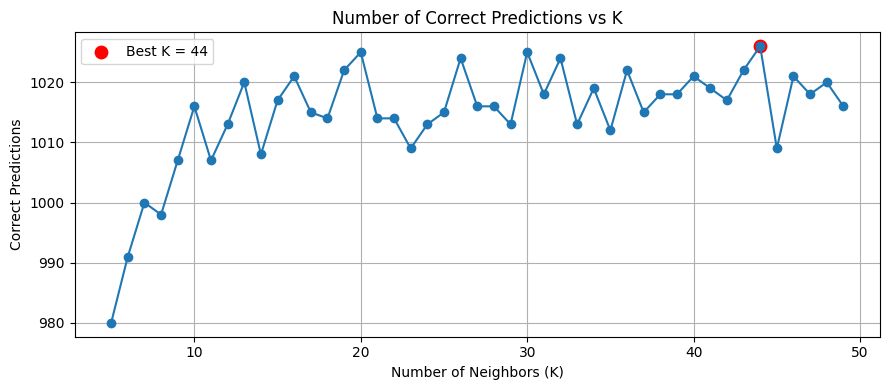

In [30]:
# Plot correct predictions vs K
plt.figure(figsize=(9,4))
plt.plot(list(k_values), correct_sum, marker='o')
plt.title('Number of Correct Predictions vs K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Correct Predictions')
plt.grid(True)
plt.scatter([best_k], [best_correct], color='red', s=80, label=f'Best K = {best_k}')
plt.legend()
plt.tight_layout()
plt.show()


# **STEP 3: Manual KNN Training**

In [31]:
k_manual = 44

manual_knn = KNeighborsClassifier(n_neighbors=k_manual, metric='manhattan', weights='uniform')

#  Train the model
manual_knn.fit(X_train_imputed, y_train)

# Predict on training and testing data
y_manual_train_pred = manual_knn.predict(X_train_imputed)
y_manual_pred = manual_knn.predict(X_test_imputed)

# Calculate metrics
manual_train_acc = accuracy_score(y_train, y_manual_train_pred)
manual_test_acc = accuracy_score(y_test, y_manual_pred)
manual_f1 = f1_score(y_test, y_manual_pred)
manual_precision = precision_score(y_test, y_manual_pred)
manual_recall = recall_score(y_test, y_manual_pred)
manual_roc = roc_auc_score(y_test, y_manual_pred)
manual_cm = confusion_matrix(y_test, y_manual_pred)

# Print results
print(f"\n Manual K = {k_manual} Evaluation Metrics:")
print(f"Training Accuracy: {manual_train_acc:.4f}")
print(f"Testing Accuracy:  {manual_test_acc:.4f}")
print(f"F1 Score: {manual_f1:.4f}")
print(f"Precision: {manual_precision:.4f}")
print(f"Recall: {manual_recall:.4f}")
print(f"ROC-AUC: {manual_roc:.4f}")
print("Confusion Matrix:")
print(manual_cm)


 Manual K = 44 Evaluation Metrics:
Training Accuracy: 0.7423
Testing Accuracy:  0.7600
F1 Score: 0.7712
Precision: 0.6947
Recall: 0.8667
ROC-AUC: 0.7667
Confusion Matrix:
[[480 240]
 [ 84 546]]


# **STEP 4: Automatic Best KNN (GridSearchCV)**

In [32]:
param_grid = {
    'n_neighbors': range(5, 40),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)

best_knn = grid_search.best_estimator_

# Predictions
y_train_pred = best_knn.predict(X_train_imputed)
y_test_pred = best_knn.predict(X_test_imputed)

# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc = roc_auc_score(y_test, best_knn.predict_proba(X_test_imputed)[:,1])
cv_f1 = cross_val_score(best_knn, X_train_imputed, y_train, cv=5, scoring='f1').mean()
cm = confusion_matrix(y_test, y_test_pred)

# Print
print("\n Automatic Model Performance Metrics:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Mean CV F1 Score: {cv_f1:.4f}")

print("\nBest Hyperparameters selected by GridSearchCV:")
print(grid_search.best_params_)


 Automatic Model Performance Metrics:
Training Accuracy: 0.7401
Testing Accuracy:  0.7519
F1 Score: 0.7629
Precision: 0.6884
Recall: 0.8556
ROC-AUC: 0.8395
Confusion Matrix:
[[476 244]
 [ 91 539]]
Mean CV F1 Score: 0.7445

Best Hyperparameters selected by GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 37, 'weights': 'uniform'}


## **STEP 5: Manual vs Automatic Comparison**

In [33]:
# Define variables for comparison
manual_train_acc = accuracy_score(y_train, y_manual_train_pred)
manual_test_acc = manual_test_acc
manual_prec = manual_precision
manual_rec = manual_recall
manual_f1_val = manual_f1
manual_roc_val = manual_roc
manual_cv_f1 = 0.0
manual_cm_val = manual_cm

auto_train_acc = accuracy_score(y_train, y_train_pred)
auto_test_acc = test_acc
auto_prec = prec
auto_rec = rec
auto_f1_val = f1
auto_roc_val = roc
auto_cv_f1 = cv_f1
auto_cm_val = cm

# Print comparison table
print("=== Manual vs Automatic KNN Comparison ===")
print(f"Manual K = {k_manual}")
print(f"Automatic best params: {grid_search.best_params_}")
print()
print(f"{'Metric':<20} {'Manual':>10} {'Automatic':>12}")
print(f"{'Train Accuracy':<20} {manual_train_acc:10.4f} {auto_train_acc:12.4f}")
print(f"{'Test Accuracy':<20} {manual_test_acc:10.4f} {auto_test_acc:12.4f}")
print(f"{'Precision':<20} {manual_prec:10.4f} {auto_prec:12.4f}")
print(f"{'Recall':<20} {manual_rec:10.4f} {auto_rec:12.4f}")
print(f"{'F1 Score':<20} {manual_f1_val:10.4f} {auto_f1_val:12.4f}")
print(f"{'ROC-AUC':<20} {manual_roc_val:10.4f} {auto_roc_val:12.4f}")
print(f"{'CV F1 (5-fold)':<20} {manual_cv_f1:10.4f} {auto_cv_f1:12.4f}")
print()

=== Manual vs Automatic KNN Comparison ===
Manual K = 44
Automatic best params: {'metric': 'manhattan', 'n_neighbors': 37, 'weights': 'uniform'}

Metric                   Manual    Automatic
Train Accuracy           0.7423       0.7401
Test Accuracy            0.7600       0.7519
Precision                0.6947       0.6884
Recall                   0.8667       0.8556
F1 Score                 0.7712       0.7629
ROC-AUC                  0.7667       0.8395
CV F1 (5-fold)           0.0000       0.7445



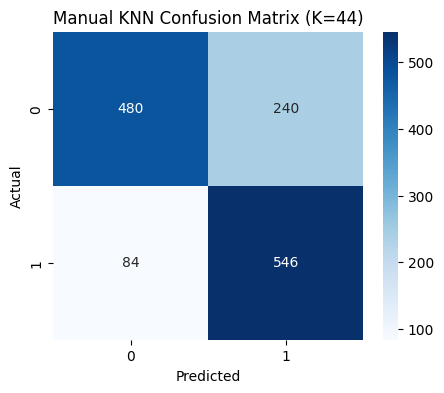

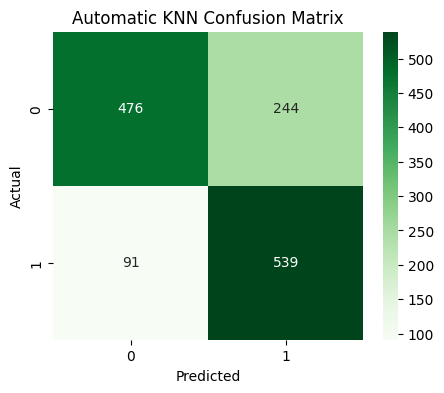

In [34]:
# Manual KNN Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(manual_cm_val, annot=True, fmt='d', cmap='Blues')
plt.title(f'Manual KNN Confusion Matrix (K={k_manual})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Automatic KNN Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(auto_cm_val, annot=True, fmt='d', cmap='Greens')
plt.title(f'Automatic KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
